## Example of using pyuvwsim for generating baseline coordinates.

Assumed position of VLA site: 
- lon = -107.618363
- lat = 34.078358
- alt = 0 m

Assumed position of SKA1 LFAA site:
- lon = 116.631289 deg
- lat = -26.697024 deg
- alt = 0 m

Assumed position of SKA1 Mid site:
- lon = 21.442909
- lat = -30.739475
- alt = 0 m

##### Zenith direction calculated in CASA with the following code:

```
#
# run in CASA with:
#   execfile('calculate_zenith_direction.py'
# or from the command line with:
# casapy --nogui --nologger --log2term -c calculate_zenith_direction.py
#

if __name__ == '__main__':

    import numpy as np

    lon      = 116.631289
    lat      = -26.697024
    alt      = 0.0
    t0_year  = 2015
    t0_month = 4
    t0_day   = 15
    t0_hour  = 12
    t0_min   = 0
    t0_sec   = 0
    t0_utc   = '%04i/%02i/%02i/%02i:%02i:%05.2f' % \
        (t0_year, t0_month, t0_day, t0_hour, t0_min, t0_sec)
    az0 = 0.0
    el0 = 90.0

    # Lon,lat of the telescope
    p0 = me.position('WGS84', qa.quantity(lon, 'deg'), qa.quantity(lat, 'deg'),
        qa.quantity(alt, 'm'))

    # Convert az, el and time to celestial coordiantes.
    d0 = me.direction('AZEL', qa.quantity(az0, 'deg'), qa.quantity(el0, 'deg'))
    e = me.epoch('UTC', t0_utc)
    t_mjd_utc = e['m0']['value']
    qt = qa.quantity(t_mjd_utc, unitname='d')
    qa.time(qt, form="ymd")
    me.doframe(e)
    me.doframe(p0)
    d = me.measure(d0, 'J2000')
    ra  = d['m0']['value']*(180./np.pi)
    dec = d['m1']['value']*(180./np.pi)
    stime = qa.time(qt, form=["ymd"])[0]
    print '='*80
    print '* lon  = %f' % lon
    print '* lat  = %f' % lat
    print '* alt  = %f' % alt
    print '* az   = %s' % az0
    print '* el   = %s' % el0
    print '* time = %s' % stime
    print '* ra   = %f' % ra
    print '* dec  = %f' % dec
    print '='*80
```

##### Coordinate times vs observation length
<img src="sim_times.png"/>



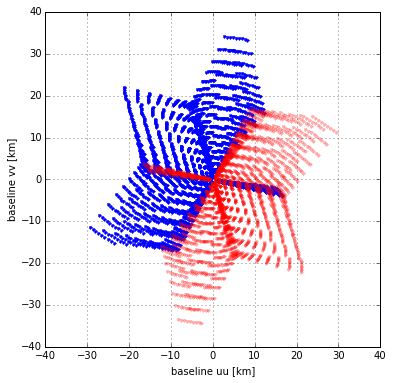

In [3]:
%matplotlib inline
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pp
import urllib
import os
import pyuvwsim as pyuvw

# Download the VLA positions
VLA_A_cfg_file = 'VLA_A_hor_xyz.txt'
VLA_A_cfg_url  = 'https://raw.githubusercontent.com/' \
    'SKA-ScienceDataProcessor/uvwsim/' \
    'master/test/data/'+VLA_A_cfg_file
fh = open(VLA_A_cfg_file, 'w')
fh.write(urllib.urlopen(VLA_A_cfg_url).read())
fh.close()

# Load station coordinates from the downloaded data file
(x,y,z) = pyuvw.load_station_coords(VLA_A_cfg_file)

# Convert to ECEF coordinates
lon = -107.618363
lat = 34.078358
alt = 0
(x,y,z) = pyuvw.convert_enu_to_ecef(x,y,z,lon,lat,alt)

# Define observation start time, in MJD
t0  = pyuvw.datetime_to_mjd(2015, 4, 15, 12, 0, 0.0);

# Define an observation direction.
ra  = -84.429670
dec = 33.893647

# Evaluate baseline coordinates
num_times = 9 # Must be odd !
obs_length = 1./24. # days
t_inc = obs_length/float(num_times)
t_start = t0-(obs_length/2.)+(t_inc/2.)
uu=[]; vv=[]; ww=[]
for i in range(0, num_times):
    mjd = t_start+t_inc*i
    #print '[%3i] delta_t = % -.5f min.' % (i, ((-obs_length/2.)+(t_inc/2.)+t_inc*i)*24*60.0)
    (uu_,vv_,ww_) = pyuvw.evaluate_baseline_uvw(x, y, z, ra, dec, mjd)
    uu = np.append(uu, uu_)
    vv = np.append(vv, vv_)
    ww = np.append(vv, ww_)

# Plot the baseline distribution
fig = pp.figure(1, figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu/1.e3, vv/1.e3, 'b.')
ax.plot(-uu/1.e3, -vv/1.e3, 'r.', alpha=0.3)
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_xlabel('baseline uu [km]')
ax.set_ylabel('baseline vv [km]')
pp.grid()

# Remove the Downloaded SKA1 low config
os.remove(VLA_A_cfg_file)


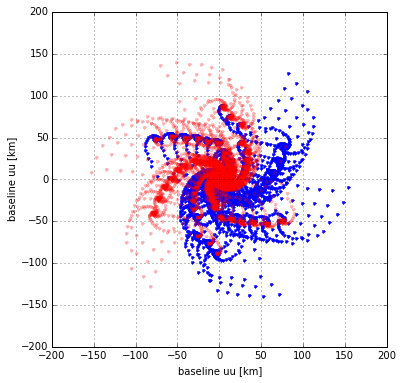

In [9]:
%matplotlib inline
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pp
import urllib
import os
import pyuvwsim as pyuvw

# Download the SKA1 mid config from github
ska1_mid_cfg_file = 'SKA1_mid_ecef.txt'
ska1_mid_cfg_url = 'https://raw.githubusercontent.com/'\
    'SKA-ScienceDataProcessor/'\
    'uvwsim/master/test/data/'+ska1_mid_cfg_file
fh = open(ska1_mid_cfg_file, 'w')
fh.write(urllib.urlopen(ska1_mid_cfg_url).read())
fh.close()

# Load station coordinates from the downloaded data file
(x,y,z) = pyuvw.load_station_coords(ska1_mid_cfg_file)

# Define observation start time, in MJD
t0  = pyuvw.datetime_to_mjd(2015, 4, 15, 12, 0, 0.0);

# Define an observation direction.
# Assumed lat,lon = (-30.739475,21.442909)
ra  = 44.619259
dec = -30.626991

# Evaluate baseline coordinates
mjd = t0
(uu,vv,ww) = pyuvw.evaluate_baseline_uvw(x, y, z, ra, dec, mjd)

# Plot the baseline distrubution
fig = pp.figure(1, figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu/1.e3, vv/1.e3, 'b.')
ax.plot(-uu/1.e3, -vv/1.e3, 'r.', alpha=0.3)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_xlabel('baseline uu [km]')
ax.set_ylabel('baseline vv [km]')
pp.grid()

# Remove the Downloaded SKA1 mid config
os.remove(ska1_mid_cfg_file)



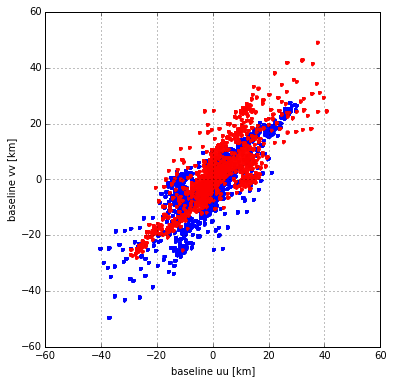

In [3]:
%matplotlib inline
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pp
import urllib
import os
import pyuvwsim as pyuvw

# Download the SKA1 low config from github
ska1_low_cfg_file = 'SKA1_low_ecef.txt'
ska1_low_cfg_url = 'https://raw.githubusercontent.com/'\
    'SKA-ScienceDataProcessor/'\
    'uvwsim/master/test/data/'+ska1_low_cfg_file
fh = open(ska1_low_cfg_file, 'w')
fh.write(urllib.urlopen(ska1_low_cfg_url).read())
fh.close()

# Load station coordinates from the downloaded data file
(x,y,z) = pyuvw.load_station_coords(ska1_low_cfg_file)

# Define observation start time, in MJD
t0  = pyuvw.datetime_to_mjd(2015, 4, 15, 12, 0, 0.0);

# Define an observation direction.
# Assumed lon,lat = (116.631289, -26.697024)
ra  = 139.789425
dec = -26.472055

# Evaluate baseline coordinates
mjd = t0
uu = []
vv = []
ww = []
(uu,vv,ww) = pyuvw.evaluate_baseline_uvw(x, y, z, ra, dec, mjd)

# Plot the baseline distrubution
fig = pp.figure(1, figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu/1.e3, vv/1.e3, 'b.')
ax.plot(-uu/1.e3, -vv/1.e3, 'r.', alpha=0.3)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('baseline uu [km]')
ax.set_ylabel('baseline vv [km]')
pp.grid()

# Remove the Downloaded SKA1 low config
os.remove(ska1_low_cfg_file)
